# CMI - Detect Behavior With Sensor Data - Revised EDA

## Overview of Revisions

###  Objectives

## Setup and Load Data

In [1]:
from pathlib import Path
import pickle, gzip, os, time, gc
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", None):
        display(df)

In [3]:
competition_name = "cmi-detect-behavior-with-sensor-data"
project_dir = Path(os.path.expanduser("~/code/kaggle/kaggle-cmi-detect-behavior"))

In [6]:
train_path = project_dir/'data/train.csv'
train_demo_path = project_dir/'data/train_demographics.csv'
test_path = project_dir/'data/test.csv'
test_demo_path =project_dir/'data/test_demographics.csv'

#Load DFs once, convert to feather format and comment out
#train = pd.read_csv(train_path)
#train_demo = pd.read_csv(train_demo_path)

# Test DFs - ONLY for data structure
test = pd.read_csv(test_path)
test_demo = pd.read_csv(test_demo_path)
test_full = test.merge(test_demo, left_on='subject', right_on='subject', how='left')


In [ ]:
# Merging sensor training data with demographics data
# Execute once
#train_full = train.merge(train_demo, left_on='subject', right_on='subject', how='left')

#print(f"Shape of merged training data: {train_full.shape}")
#print("Columns: ", train_full.columns.to_list())

Shape of merged training data: (574945, 348)
Columns:  ['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase', 'gesture', 'acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v52', 'tof_1_v53', 'tof_1_v54', 'tof_1_v55'

In [ ]:
# Save and reload from feather format
#train_full.to_feather('processed_data/train_full.feather')
train_full = pd.read_feather('processed_data/train_full.feather')

## Revised EDA

### Test Data Awareness Analysis

Selecting a representative sample of from each major sensor group to act as a proxy for the entire group:

- IMU (acc_x, acc_y, acc_z, rot_w, rot_x): The underlying assumption is that if there is a significant data drift between the train and test sets, it will likely be present across all axes of a given sensor. For example, if acc_x shows a major distributional shift, it is highly probable that acc_y and acc_z will as well. By checking a few, we can get a strong signal for the health of the entire IMU group.

- Thermopile (thm_1, thm_5): From our initial EDA, we know that thm_5 had a much higher rate of missingness than thm_1 through thm_4. By specifically plotting thm_1 (representative of the "good" sensors) and thm_5 (the "problematic" sensor), we can quickly check if this distinct missingness or behavioral pattern also exists in the test data.

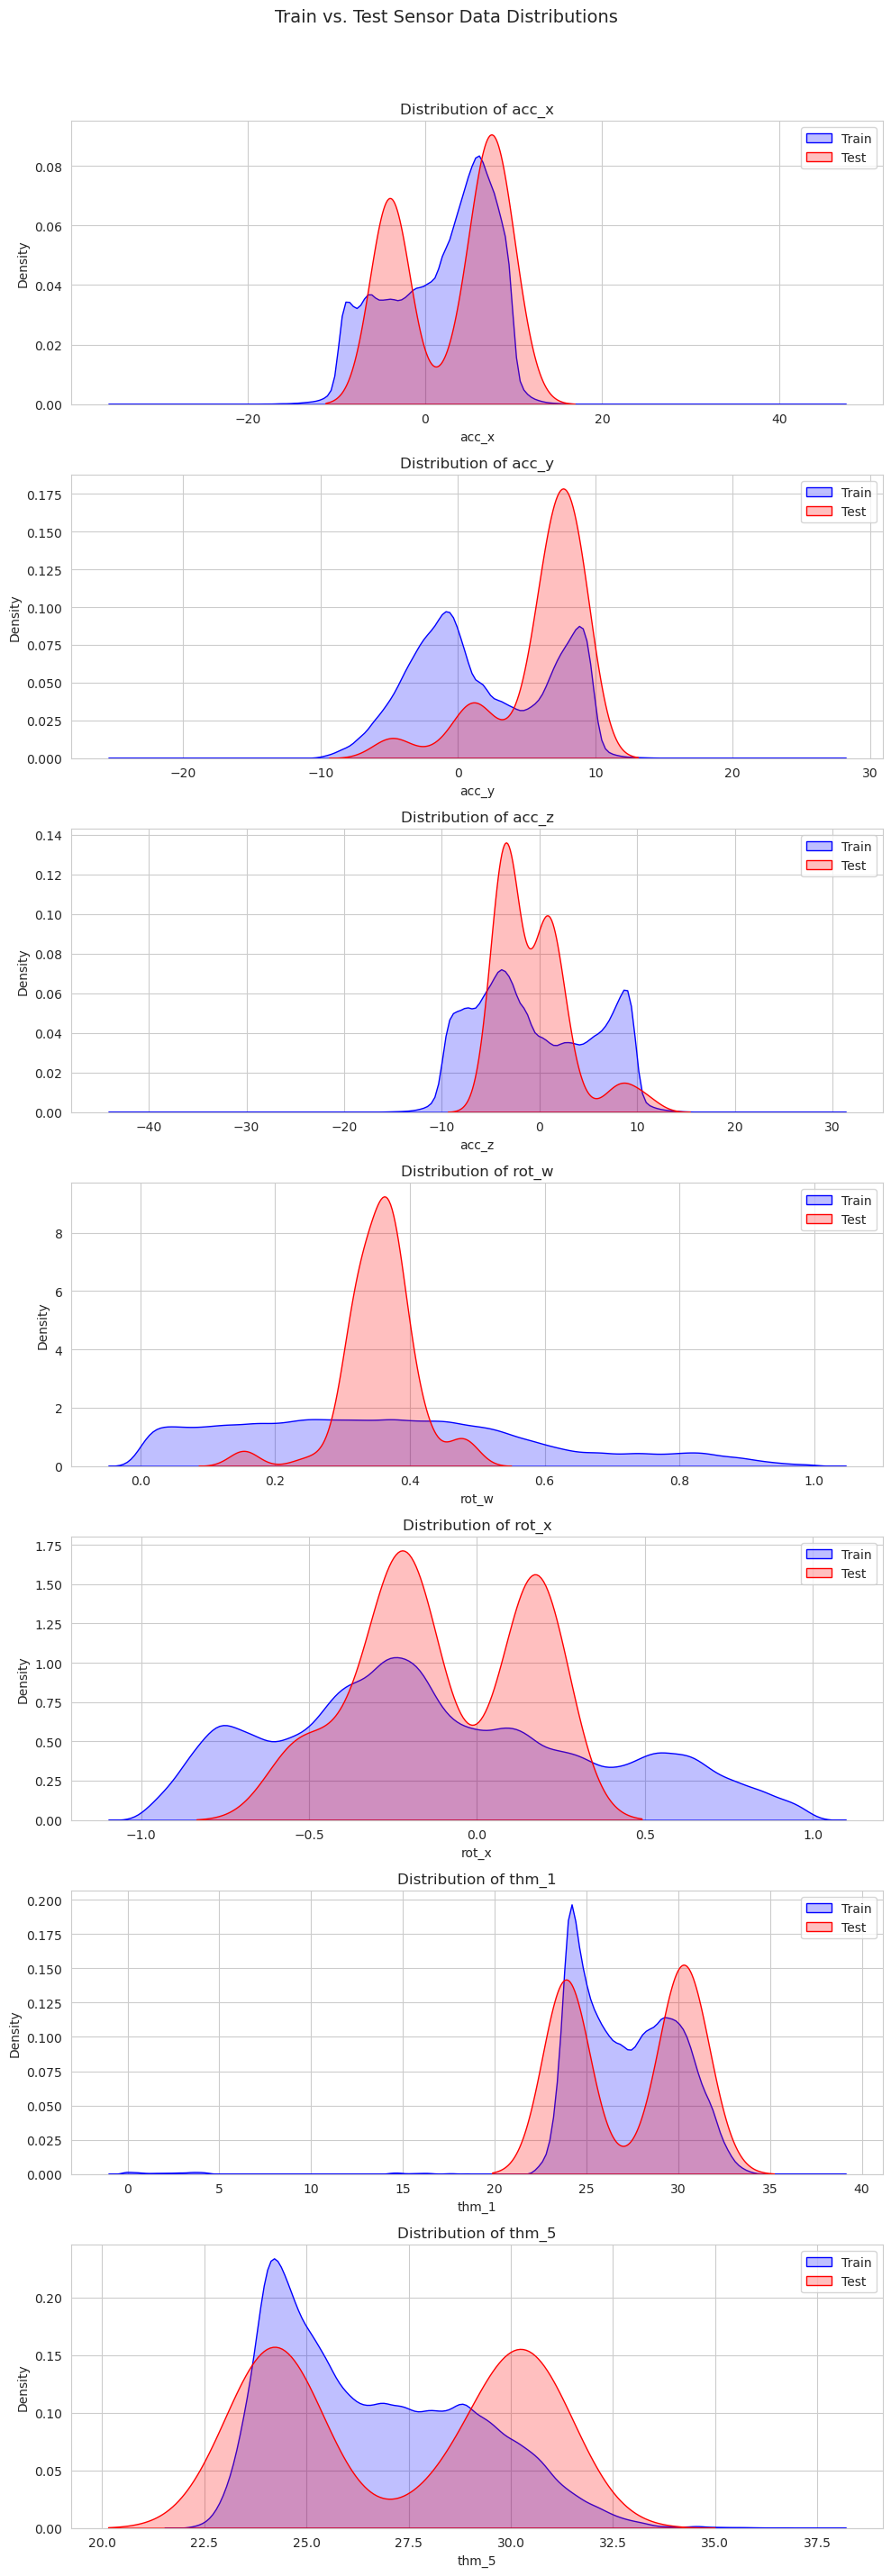

In [9]:
sen_to_col_compare = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'thm_1', 'thm_5']

fig, axes = plt.subplots(len(sen_to_col_compare), 1, figsize=(10, 4 * len(sen_to_col_compare)))
fig.suptitle('Train vs. Test Sensor Data Distributions', fontsize=14, y=1.02)

for i, col in enumerate(sen_to_col_compare):
    sns.kdeplot(train_full[col].dropna(), ax=axes[i], label='Train', color='blue', shade=True)
    sns.kdeplot(test_full[col].dropna(), ax=axes[i], label='Test', color='red', shade=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()
    
plt.tight_layout()
plt.show();

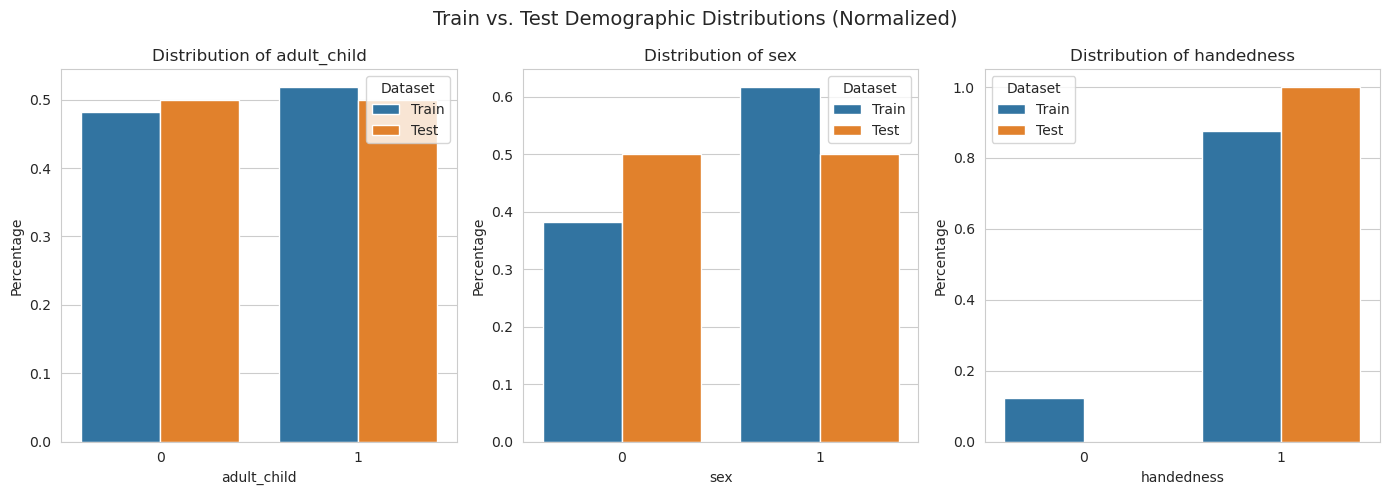

In [19]:
# Compare demographic data distributions
demo_cols_compare = ['adult_child', 'sex', 'handedness']

fig, axes = plt.subplots(1, len(demo_cols_compare), figsize=(14, 5))
fig.suptitle('Train vs. Test Demographic Distributions (Normalized)', fontsize=14)

for i, col in enumerate(demo_cols_compare):
    train_cnts = train_full.drop_duplicates(subset=['subject'])[col].value_counts(normalize=True).rename('Train')
    test_cnts = test_full.drop_duplicates(subset=['subject'])[col].value_counts(normalize=True).rename('Test')
    
    combined_cnts = pd.concat([train_cnts, test_cnts], axis=1).reset_index()
    melted_cnts = combined_cnts.melt(id_vars=col, var_name='Dataset', value_name='Percentage')
    
    sns.barplot(data=melted_cnts, x=col, y='Percentage', hue='Dataset', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage')
    
plt.tight_layout()
plt.show();
    

### Sequence Structure and Phase Inference